In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

In [ ]:
# Read in data
forex_data = pd.read_csv('data/GBPUSD1m.txt', header=None)
forex_data.columns = ['Time', 'Bid', 'Ask']
forex_data['Midpoint'] = (forex_data['Bid'] + forex_data['Ask']) * 0.5
# Parse date
forex_data['Time'] = [datetime.datetime.strptime(str(x), '%Y%m%d%H%M%S') for x in forex_data['Time']]
forex_data.set_index('Time', inplace=True)
forex_data.to_csv('data/forex_csv.csv')
# Using the last day as test date
forex_data_train = forex_data[forex_data.index < pd.Timestamp('20130531')]
forex_data_test = forex_data[forex_data.index >= pd.Timestamp('20130531')]
pickle.dump(forex_data, open('data/forex_data', 'wb'))
pickle.dump(forex_data_train, open('data/forex_data_train', 'wb'))
pickle.dump(forex_data_test, open('data/forex_data_test', 'wb'))

In [ ]:
def patternList(pattern_length, forward_steps, data):
    '''
    Create patterns and target to predict
    '''
    N = len(data) - 1 - forward_steps
    pattern_list = np.zeros((N - pattern_length, pattern_length))
    outcome_list = np.zeros(N - pattern_length)
    for i in range(N - pattern_length):
        pattern = np.diff(data['Midpoint'][i:i + 1 + pattern_length])
        pattern_list[i, :] = pattern
        outcome_list[i] = data['Midpoint'][i + 1 + pattern_length + forward_steps] - data['Midpoint'][
            i + 1 + pattern_length]
        if i % 100000 == 0:
            plt.plot(pattern)
    return pattern_list, outcome_list

In [ ]:
length_of_pattern = 50
number_of_forward_steps = 10
patterns, outcomes = patternList(length_of_pattern, number_of_forward_steps, forex_data)
plt.show()
pickle.dump(patterns, open('data/patterns', 'wb'))
pickle.dump(outcomes, open('data/outcomes', 'wb'))

patterns_train, outcomes_train = patternList(length_of_pattern, number_of_forward_steps, forex_data_train)
patterns_test, outcomes_test = patternList(length_of_pattern, number_of_forward_steps, forex_data_test)

pickle.dump(patterns_train, open('data/patterns_train', 'wb'))
pickle.dump(outcomes_train, open('data/outcomes_train', 'wb'))
pickle.dump(patterns_test, open('data/patterns_test', 'wb'))
pickle.dump(outcomes_test, open('data/outcomes_test', 'wb'))

In [2]:
length_of_pattern = 50
number_of_forward_steps = 10

X = pickle.load(open('data/patterns', 'rb'))
y = pickle.load(open('data/outcomes', 'rb'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# Avoid data leak
X_train = 1e4 * X_train
X_test = 1e4 * X_test
# Identify if price increases or not， use as target
y_train_bin = y_train > 0
y_test_bin = y_test > 0

In [34]:
forex = pickle.load(open('data/forex_data', 'rb'))
forex.head()

,Bid,Ask,Midpoint
Time,,,
2013-05-01,1.55358,1.55371,1.553645
2013-05-01,1.55357,1.55369,1.553630
2013-05-01,1.55353,1.55367,1.553600
2013-05-01,1.55349,1.55367,1.553580
2013-05-01,1.55349,1.55367,1.553580


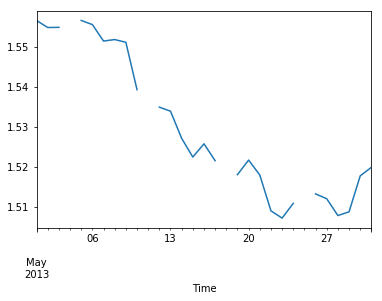

In [22]:
%matplotlib inline
forex['Midpoint'].resample('D').mean().plot()
plt.show()

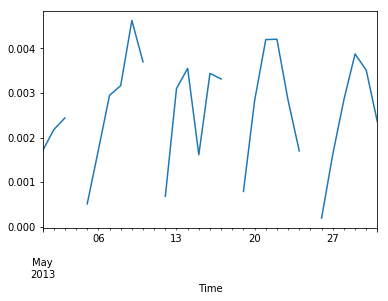

In [23]:
%matplotlib inline
forex['Midpoint'].resample('D').std().plot()
plt.show()

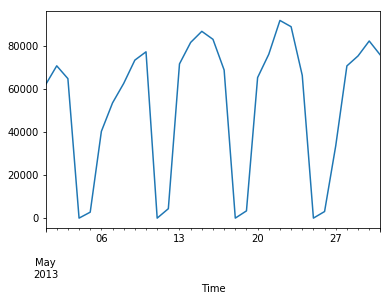

In [25]:
%matplotlib inline
forex['Midpoint'].resample('D').count().plot()
plt.show()

In [3]:
print(X_train.shape)
logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train_bin)
logit_pred = logit_clf.predict(X_train)
logit_correct_pred = logit_pred[logit_pred == y_train_bin]

(1310240, 50)


In [4]:
y_train_pred = cross_val_predict(logit_clf, X_train, y_train_bin, cv=10)

In [5]:
conf_mx = confusion_matrix(y_train_bin, y_train_pred)
print(conf_mx)

[[576591 104694]
 [513179 115776]]


In [15]:
from __future__ import division
logit_success_rate = len(logit_correct_pred)/len(logit_pred)
logit_test_pred = logit_clf.predict(X_test)
logit_test_acc = len(y_test_bin[y_test_bin == logit_test_pred])/len(y_test_bin)
print('Logistic Regression Model fit on training data with random split', logit_success_rate)
print('Logistic Regression Model fit on test data with random split', logit_test_acc)

('Logistic Regression Model fit on training data with random split', 0.5288107522285993)
('Logistic Regression Model fit on test data with random split', 0.5288313591403102)


In [26]:
# use last day data as test
X_train = pickle.load(open('data/patterns_train', 'rb'))
y_train = pickle.load(open('data/outcomes_train', 'rb'))

X_train = 1e4 * X_train
y_train_bin = y_train > 0

logit_clf.fit(X_train,y_train_bin)

y_train_pred = cross_val_predict(logit_clf, X_train, y_train_bin,cv=3)
logit_correct_pred = y_train_pred[y_train_pred == y_train_bin]

correct_down_move_pred = len(y_train_bin[~y_train_bin & ~y_train_pred])/len(y_train_bin[~y_train_bin])
correct_up_move_pred = len(y_train_bin[y_train_bin & y_train_pred])/len(y_train_bin[y_train_bin])

print('Correct down move prediction: ', correct_down_move_pred)
print('Correct up move prediction', correct_up_move_pred)

('Correct down move prediction: ', 0.8536055806771268)
('Correct up move prediction', 0.17484154071184788)


In [27]:
conf_train_mx = confusion_matrix(y_train_bin,y_train_pred)
print('Confusion matrix', conf_train_mx)
logit_train_success_rate = float(len(logit_correct_pred))/len(y_train_pred)
print('Logistic Regression fit', logit_train_success_rate)

('Confusion matrix', array([[694304, 119074],
       [617726, 130889]]))
('Logistic Regression fit', 0.528294941142502)


In [28]:
X_test = pickle.load(open('data/patterns_test', 'rb'))
X_test = 1e4 * X_test
y_test = pickle.load(open('data/outcomes_test', 'rb'))

y_test_bin = y_test > 0
logit_test_pred = logit_clf.predict(X_test)
logit_test_acc = len(y_test_bin[y_test_bin == logit_test_pred])/len(y_test_bin)
print('Logistic Regression Model test accuracy', logit_test_acc)

print(len(y_test_bin[~y_test_bin]))
print(len(logit_test_pred[~logit_test_pred]))
print(len(y_test_bin))


conf_test_mx = confusion_matrix(y_test_bin, logit_test_pred)

print('Test confusion matrix: ', conf_test_mx)

('Logistic Regression Model test accuracy', 0.5263776305019408)
38898
61633
75746
('Test confusion matrix: ', array([[32328,  6570],
       [29305,  7543]]))


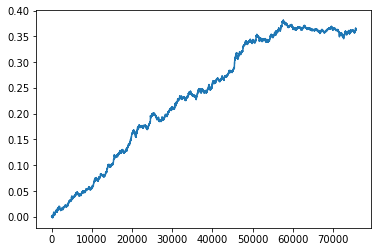

In [29]:
def profit(predictions, data):
    profit_loss = []
    for i in range(len(predictions)):
        if predictions[i]:
            profit_loss.append(data[i])
        else:
            profit_loss.append(-data[i])
    return np.cumsum(profit_loss)

P_L_test = profit(logit_test_pred,y_test)
plt.plot(P_L_test, label='Logistic Regression Model')

In [30]:
coin_flips = np.random.binomial(1, 0.5, len(y_test))
P_L_random = profit(coin_flips, y_test)

print(confusion_matrix(coin_flips,y_test_bin))

[[19474 18411]
 [19424 18437]]


In [31]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train_bin)

P_L_lda = profit(lda_clf.predict(X_test), y_test)

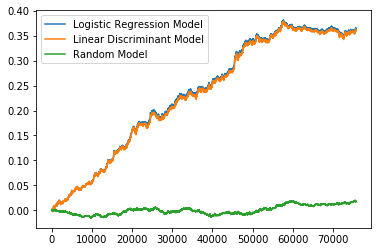

In [33]:
plt.plot(P_L_test, label='Logistic Regression Model')
plt.plot(P_L_lda, label='Linear Discriminant Model')
plt.plot(P_L_random, label='Random Model')
plt.legend(loc='upper left')
plt.show()


In [36]:
def long_short(pattern_length, forward_steps, data):
    '''
    Create long_short list to help making decision to long, short or do nothing.
    For certain time point, Ask (buy) >  Bid (sell). Otherwise, it becomes an arbitrage.
    If Bid[forward] > Ask[current], then we should buy.
    If Bid[current] > Ask[forward], then we should sell.
    Otherwise, we do nothing. 
    The target becomes a tri-state variable.
    '''
    N = len(data) - 1 - forward_steps
    long_short_list = []
    for i in range(N - pattern_length):
        long_short_list.append(
            (data['Bid'][i + 1 + pattern_length + forward_steps] - data['Ask'][i + 1 + pattern_length], \
             data['Ask'][i + 1 + pattern_length + forward_steps] - data['Bid'][i + 1 + pattern_length]))
    return long_short_list

In [37]:
length_of_pattern = 50
number_of_forward_steps = 10

forex_data_train = pickle.load(open('data/forex_data_train', 'rb'))
forex_data_test = pickle.load(open('data/forex_data_test', 'rb'))

bid_ask_train = long_short(length_of_pattern, number_of_forward_steps, forex_data_train)
bid_ask_test = long_short(length_of_pattern, number_of_forward_steps, forex_data_test)

pickle.dump(bid_ask_train, open('data/bid_ask_train', 'wb'))
pickle.dump(bid_ask_test, open('data/bid_ask_test', 'wb'))

In [38]:
X_train =pickle.load(open('data/patterns_train','rb'))
y_train =pickle.load(open('data/bid_ask_train','rb'))
X_train = 1e4 * X_train
X_test =pickle.load(open('data/patterns_test','rb'))
X_test = 1e4 * X_test
y_test =pickle.load(open('data/bid_ask_test','rb'))